# Steane Code: Encoding in IonQ

In this notebook we create a $\ket{0}_L$ state using the Steane Code and perform a measurement in $Z_L = Z^{\otimes 7}$ (The logical $Z$ operator). The expected resul of the measurement is $0$. 

In [1]:
# Imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RXGate, UGate, IGate
from qiskit.circuit import QuantumCircuit, Delay
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService

import azure.quantum
from azure.quantum import Workspace 
from azure.quantum.qiskit import AzureQuantumProvider

import sys
import os

# Tenemos que agregar ".." a nuestro sys.path para usar SteaneCodeCircuit
sys.path.append(os.path.abspath("../../.."))
from objects.steane_code_circuit import SteaneCodeCircuit
from functions import *

### Backend Definition:

In [2]:
# IonQ acces
workspace = Workspace(  
    resource_id = "", # Add the resourceID of your workspace
    location = "" # Add the location of your workspace (for example "westus")
    )

provider = AzureQuantumProvider(workspace)

In [3]:
backend_name = "ionq.qpu.aria-1"
backend_name_simulator = "ionq.simulator"
backend = provider.get_backend(backend_name)
simulator_backend = provider.get_backend(backend_name_simulator)

option_params = {
    "error-mitigation": {
        "debias": False,
        "sharpen": False
    }
}

backend.options.update_options(**option_params)
simulator_backend.options.update_options(**option_params)
simulator_backend.options.update_options(noise_model="aria-1") 

### Circuit definition:

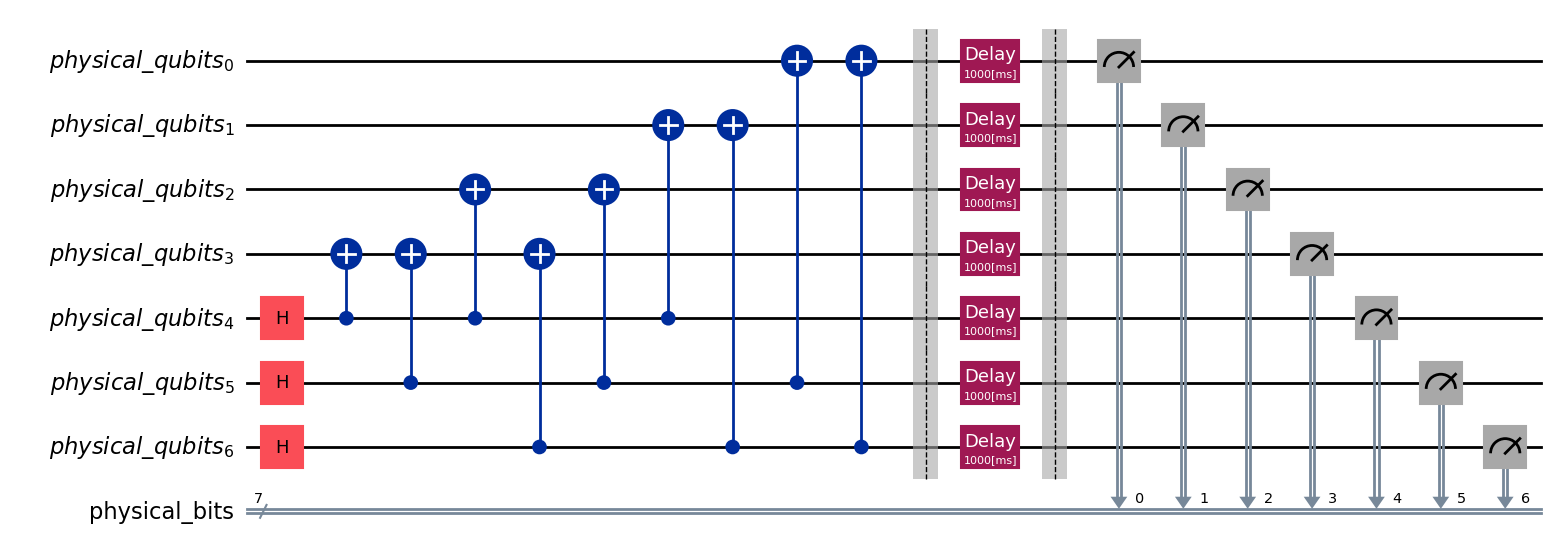

In [4]:
qc_steane = SteaneCodeCircuit(logical_qubit_count = 1)
qc_steane.encode(append=True, initial_state='0')
qc_steane.barrier()
qc_steane.delay(1000, unit='ms')
qc_steane.barrier()
qc_steane.measure_all("all")

qc = qc_steane.physical_quantum_circuit



qc.draw("mpl")

### Simulation of the circuit:

This is a simulation whith the noise model of aria-1 and error-mitigation off. We can check that the setting is correct by running $\textcolor{orange}{\text{simulator\_backend.options}}$

In [5]:
simulator_backend.options

Options(shots=500, target_profile=TargetProfile.Base, error-mitigation={'debias': False, 'sharpen': False}, noise_model='aria-1')

### Run in Aria-1

We create a JSON file with the information of the result

In [6]:
print("This workspace's targets:")
for b in provider.backends():
    print("- " + b.name())

This workspace's targets:
- ionq.simulator
- ionq.qpu.aria-1
- ionq.qpu.aria-2


In [7]:
backend.options # Check if the error-mitigation option is off

Options(shots=500, target_profile=TargetProfile.Base, error-mitigation={'debias': False, 'sharpen': False})

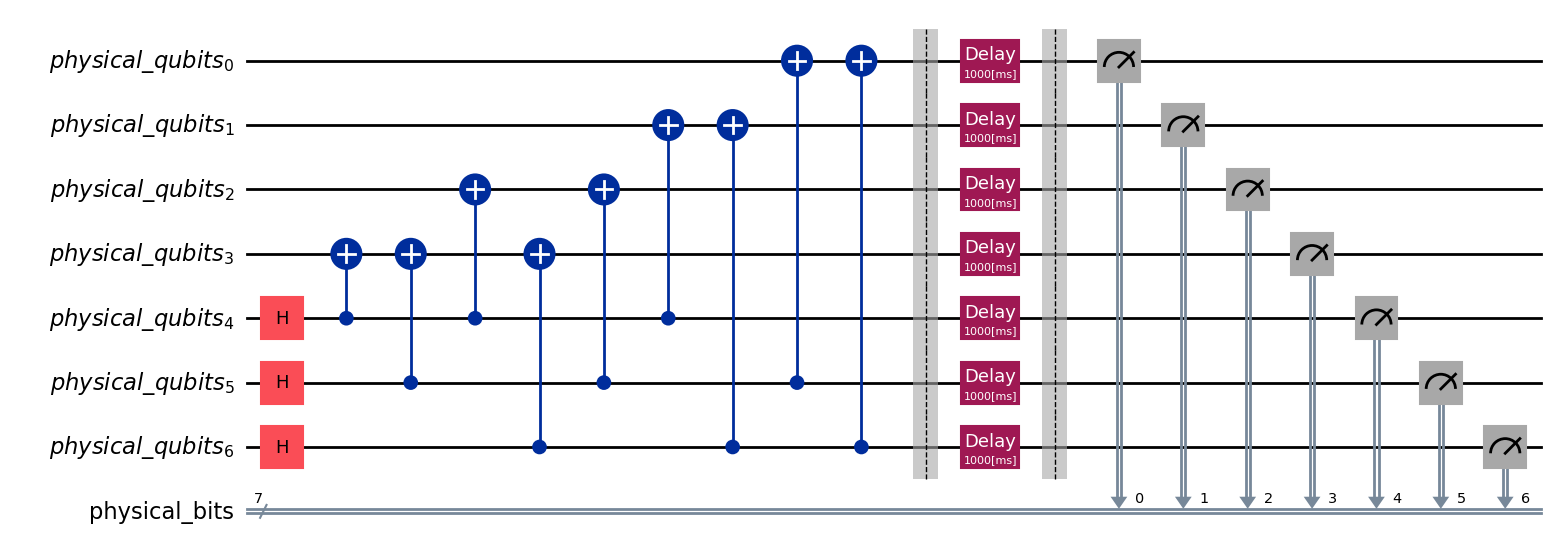

In [8]:
# Check the circuit:
qc.draw("mpl")

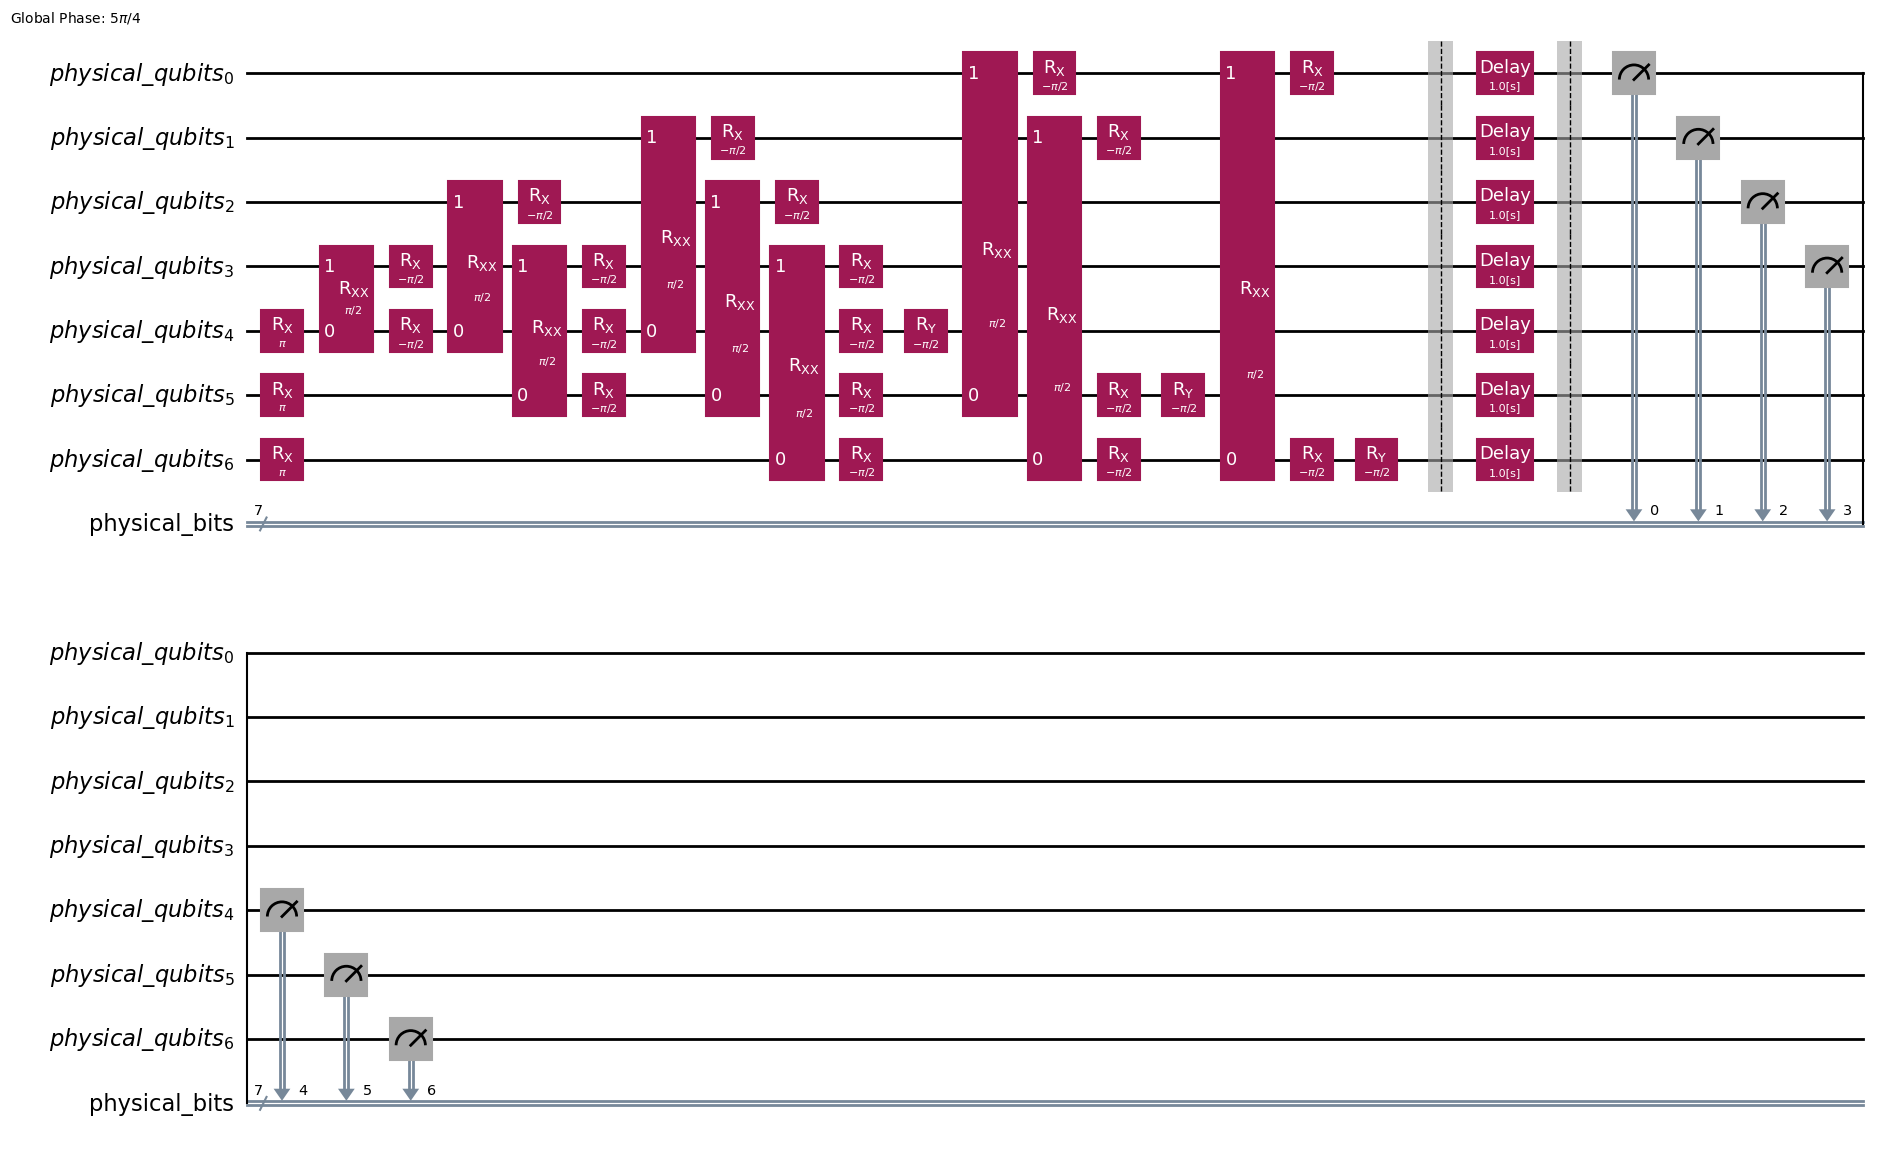

In [9]:
# Estimate the depth:

tqc = transpile(qc, basis_gates=['rx', 'ry', 'rz', 'rxx', 'id'])
tqc.draw("mpl")

In [10]:
tqc.count_ops()

OrderedDict([('rx', 21),
             ('rxx', 9),
             ('delay', 7),
             ('measure', 7),
             ('ry', 3),
             ('barrier', 2)])

In [11]:
sampler = SamplerV2(backend)
shots = 3200

# Transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = transpile(qc, backend, optimization_level=1)
isa_circuit.draw("mpl")
print("Depth of the circuit:", isa_circuit.depth())

Depth of the circuit: 8


In [ ]:
# # # THIS PIECE OF CODE RUNS THE CIRCUIT IN THE REAL BACKEND
# job = backend.run([isa_circuit], shots=shots)
# job_id = job.id()
# print("Job id", job_id)

Job id 7d6bfeac-f714-11ef-a330-3800255d459d


In [ ]:
results = extract_results_json_IONQ('steane_encoding_delay1s.json', type='percentage', reverse_order=True)

results = results[0]
print(results)

{'0000000': 10.75, '0000001': 0.15625, '0000010': 0.09375, '0000011': 0.0, '0000100': 0.375, '0000101': 0.0, '0000110': 0.0, '0000111': 0.46875, '0001000': 0.46875, '0001001': 0.0, '0001010': 0.09375, '0001011': 0.3125, '0001100': 0.03125, '0001101': 0.09375, '0001110': 0.15625, '0001111': 9.1875, '0010000': 0.65625, '0010001': 0.03125, '0010010': 0.0625, '0010011': 0.15625, '0010100': 0.28125, '0010101': 0.3125, '0010110': 0.0, '0010111': 0.3125, '0011000': 0.5, '0011001': 0.0, '0011010': 0.1875, '0011011': 0.25, '0011100': 0.125, '0011101': 0.09375, '0011110': 0.03125, '0011111': 0.625, '0100000': 0.15625, '0100001': 0.0, '0100010': 0.03125, '0100011': 0.46875, '0100100': 0.59375, '0100101': 0.0, '0100110': 0.3125, '0100111': 0.1875, '0101000': 0.09375, '0101001': 0.125, '0101010': 0.0, '0101011': 0.53125, '0101100': 0.78125, '0101101': 0.0625, '0101110': 0.0625, '0101111': 0.1875, '0110000': 0.09375, '0110001': 0.0625, '0110010': 0.125, '0110011': 9.21875, '0110100': 1.03125, '01101

In [21]:
states = [bin(i)[2:].zfill(7) for i in range(2**7)]
valid_states = [s[::-1] for s in sampler_simulation(isa_circuit, 3200).data['physical_bits'].get_counts()]

In [22]:
print(valid_states)

['0111100', '1011010', '0000000', '1100110', '1010101', '0001111', '1101001', '0110011']


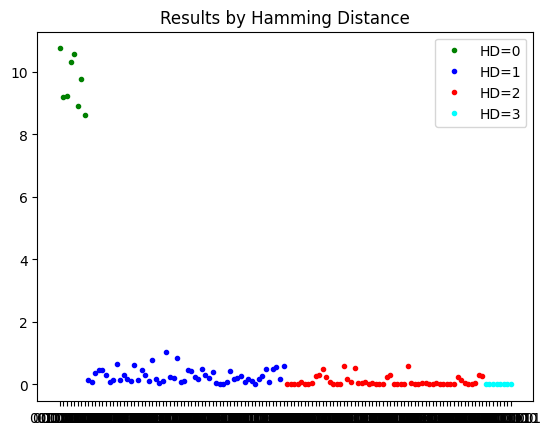

In [23]:
plot_results_hamming_distance(results, 7, valid_states)

In [24]:
tvd = calculate_tvd(results, generate_uniform_distribution(7, valid_states), percentage=True)

print(f"Total Variation Distance: {round(tvd*100,2)}%")

Total Variation Distance: 22.66%
